In [1]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib, torch, time, h5py
import numpy as np

from sklearn.metrics import mean_squared_error

import neuravi

import viscopy as vp

device = torch.device('cpu') #get_default_device()
print(device)

import mpltern
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

cpu


In [7]:
class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_n")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            #self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg', 'tvf')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

In [8]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"
path_liquidus = "./data/NKAS_liquidus.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,path_liquidus,device)


path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

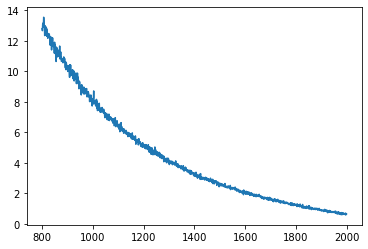

In [9]:

T_6010 = np.arange(800,2000,1.0).reshape(-1,1)

X_6010 = np.array([[0.60,0.10,0.00,0.30]]) * np.ones((len(T_6010),4))

n_6010 = neuralmodel.predict("ag",X_6010,T_6010).mean(axis=1)

plt.plot(T_6010,n_6010)



In [10]:
neuralmodel.predict("tg",X_6010).mean(axis=1)

array([837.8217041 , 820.1842041 , 834.87568359, ..., 823.55125122,
       826.55764771, 832.90563354])

In [12]:
tt = neuralmodel.predict("tg",X_6010,T_6010).mean(axis=1)

In [16]:
np.mean(tt)

833.418212677002

In [18]:
833-273

560

(array([  5.,  13.,  92., 198., 281., 281., 197.,  87.,  30.,  16.]),
 array([812.79800415, 816.85533325, 820.91266235, 824.96999146,
        829.02732056, 833.08464966, 837.14197876, 841.19930786,
        845.25663696, 849.31396606, 853.37129517]),
 <BarContainer object of 10 artists>)

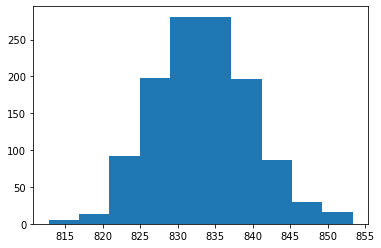

In [17]:
plt.hist(tt)

In [26]:
dfout = pd.DataFrame()

dfout["T, K"] = T_6010.ravel()
dfout["viscosity, log Pa s"] = n_6010.ravel()
dfout.to_csv("../GoogleDrive/MCF/Stagiaires/Decossin/KA6010.csv")